In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../gmm_dataset_c20k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 250
LEARNING_RATE = 1e-4
PRIOR_FLAG = False
ONLY_FORWARD = True
CUDA = torch.cuda.is_available()
PATH = 'ep-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (N, K, D, MCMC_SIZE, PRIOR_FLAG, ONLY_FORWARD)

In [3]:
from local_enc import *
from global_oneshot import *
from global_enc import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_eta = Enc_eta(K, D, CUDA, DEVICE, Reparameterized)
oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
    enc_eta.cuda().to(DEVICE)
if PRIOR_FLAG:
    optimizer =  torch.optim.Adam(list(enc_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    models = (enc_eta, enc_z)
else:
    oneshot_eta = Oneshot_eta(K, D, CUDA, DEVICE, Reparameterized)
    if CUDA:
        oneshot_eta.cuda().to(DEVICE)
    optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    models = (oneshot_eta, enc_eta, enc_z)

In [4]:
enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
enc_eta.load_state_dict(torch.load("../weights/enc-eta-%s" % PATH))
oneshot_eta.load_state_dict(torch.load("../weights/oneshot-eta-%s" % PATH))

In [5]:
import matplotlib.gridspec as gridspec


def EUBO_init_eta_test(models, obs, SubTrain_Params):
    
    (EPS, device, sample_size, batch_size, N, K, D, mcmc_size) = SubTrain_Params
    symkls_DB_eta = torch.zeros(mcmc_size).cuda().to(device)
    symkls_DB_z = torch.zeros(mcmc_size).cuda().to(device)
    esss = torch.zeros(mcmc_size+1).cuda().to(device)
    q_eta, p_eta, q_z, p_z, log_w_f_z = Init_step_eta(models, obs, N, K, D, sample_size, batch_size, prior_flag=False)
    w_f_z = F.softmax(log_w_f_z, 0).detach()

    (oneshot_eta, enc_eta, enc_z) = models
    esss[0] = (1. / (w_f_z**2).sum(0)).mean()
    
    obs_tau = q_eta['precisions'].value
    obs_mu= q_eta['means'].value
    state = q_z['zs'].value
    for m in range(mcmc_size):
        if m == 0:
            state = resample_state(state, w_f_z, idw_flag=False) ## resample state
        else:
            state = resample_state(state, w_f_z, idw_flag=True)
        q_eta, p_eta, q_nu = enc_eta(obs, state, K, D)
        obs_tau, obs_mu, log_w_eta_f, log_w_eta_b  = Incremental_eta(q_eta, p_eta, obs, state, K, D, obs_tau, obs_mu)
        symkl_detailed_balance_eta, eubo_p_q_eta, w_sym_eta, w_f_eta = detailed_balances(log_w_eta_f, log_w_eta_b, only_forward=True)
        obs_mu, obs_tau = resample_eta(obs_mu, obs_tau, w_f_eta, idw_flag=True) ## resample eta
        q_z, p_z = enc_z.forward(obs, obs_tau, obs_mu, N, K, sample_size, batch_size)
        state, log_w_z_f, log_w_z_b = Incremental_z(q_z, p_z, obs, obs_tau, obs_mu, K, D, state)
        symkl_detailed_balance_z, eubo_p_q_z, w_sym_z, w_f_z = detailed_balances(log_w_z_f, log_w_z_b, only_forward=True)
        ## symmetric KLs as metrics
        symkls_DB_eta[m] = symkl_detailed_balance_eta
        symkls_DB_z[m] = symkl_detailed_balance_z
        esss[m+1] = ((1. / (w_sym_eta**2).sum(0)).mean() + (1. / (w_sym_z**2).sum(0)).mean() ) / 2

    reused = (q_eta, q_z)
    metric_step = {"symKL_DB_eta" : symkls_DB_eta, "symKL_DB_z" : symkls_DB_z, "ess" : esss}
    return metric_step, reused

def test(models, objective, data, Model_Params, Train_Params):
    Metrics = {"symKL_DB_eta" : [], "symKL_DB_z" : [], "ess" : []}
    (NUM_DATASETS, S, B, CUDA, device, path) = Train_Params
    NUM_BATCHES = int((NUM_DATASETS / B))
    EPS = torch.FloatTensor([1e-15]).log() ## EPS for KL between categorial distributions
    if CUDA:
        EPS = EPS.cuda().to(device) ## EPS for KL between categorial distributions
    SubTrain_Params = (EPS, device, S, B) + Model_Params
#     indices = torch.randperm(NUM_DATASETS)
    indices = torch.arange(NUM_DATASETS)
    time_start = time.time()
    step = 20
    batch_indices = indices[step*B : (step+1)*B]
    obs = data[batch_indices]
    obs = shuffler(obs).repeat(S, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    _, reused = objective(models, obs, SubTrain_Params)
    return obs, reused

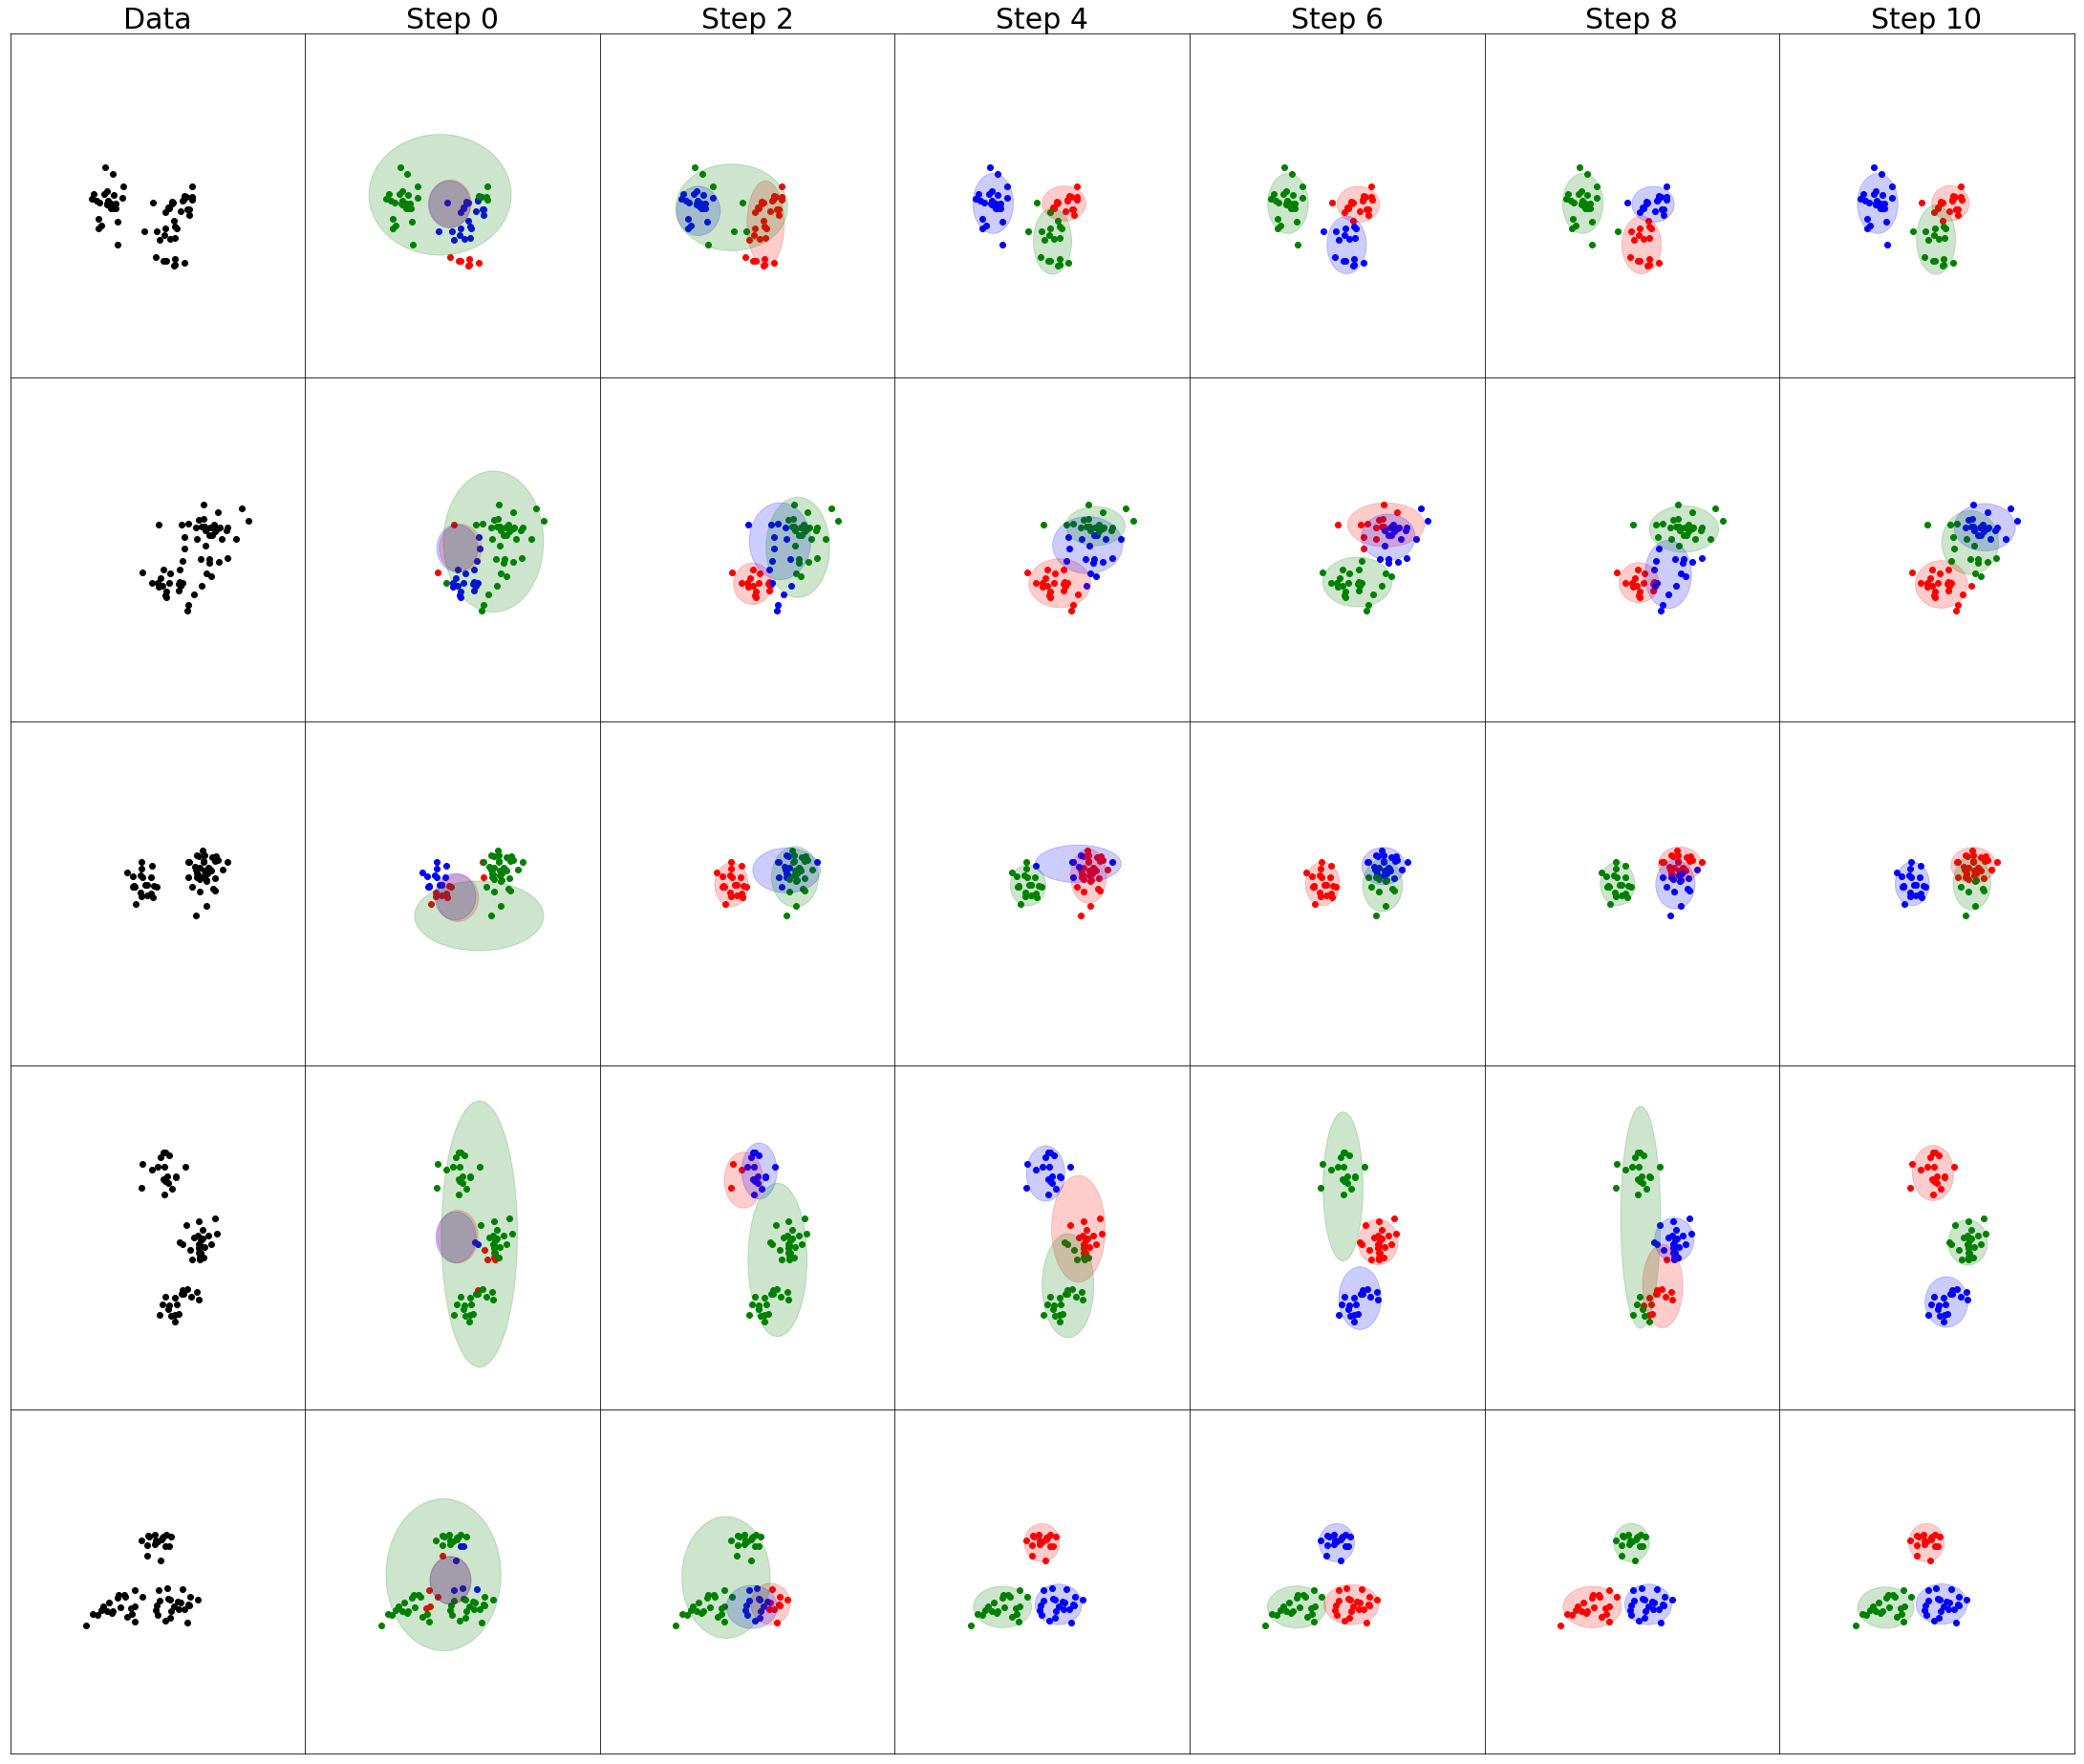

In [7]:
MAX_MCMC_STEPS = 12 ## 12 is maximum mcmc steps
SAMPLE_SIZE = 10
BATCH_SIZE = 5
Vis_Interval = 2
##
colors = ['r', 'b', 'g']
gs = gridspec.GridSpec(BATCH_SIZE, 1+int(MAX_MCMC_STEPS / Vis_Interval))
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
fig = plt.figure(figsize=(30,25))
    
EPS = torch.FloatTensor([1e-15]).log() ## EPS for KL between categorial distributions
if CUDA:
    EPS = EPS.cuda().to(DEVICE) ## EPS for KL between categorial distributions
indices = torch.arange(NUM_DATASETS)
step = 2
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
obs = Data[batch_indices]
obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    obs =obs.cuda().to(DEVICE)
    
xs = obs[0].cpu().data.numpy()    
for b in range(BATCH_SIZE):
    xb = xs[b]
    ax = fig.add_subplot(gs[b, 0])
    ax.scatter(xb[:, 0], xb[:, 1], c='k')
    ax.set_ylim([-15, 15])
    ax.set_xlim([-15, 15])
    ax.set_xticks([])
    ax.set_yticks([])
    if b == 0:
        ax.set_title('Data', fontsize=30)
for m in range(0, MAX_MCMC_STEPS, Vis_Interval):
    SubTrain_Params = (EPS, DEVICE, SAMPLE_SIZE, BATCH_SIZE) + (N, K, D, m)
    _, reused = EUBO_init_eta_test(models, obs, SubTrain_Params)
    (q_eta, q_z) = reused
    xs = obs[0].cpu().data.numpy()
    E_z = q_z['zs'].dist.probs[0].cpu().data.numpy()
    E_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
    E_tau = (q_eta['precisions'].dist.concentration[0] / q_eta['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(BATCH_SIZE):
        ax = fig.add_subplot(gs[b, 1+int(m/2)])
        xb = xs[b]
        zb = E_z[b]
        mu = E_mu[b].reshape(K, D)
        sigma2 = 1. / E_tau[b]
        assignments = zb.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k])
            xk = xb[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-15, 15])
        ax.set_xlim([-15, 15])
        ax.set_xticks([])
        ax.set_yticks([])
        if b == 0:
            ax.set_title('Step %d' % m, fontsize=30)
plt.savefig('../results/propagation' + PATH + '.svg')

In [ ]:
incremental_gap = symkl_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')